# Spotify Hackathon

<br>

<img src="https://storage.googleapis.com/pr-newsroom-wp/1/2018/11/Spotify_Logo_RGB_Green.png" alt="Spotify">

<br>
<br>

**Can you recommend new podcasts to users based on podcasts they enjoy on Spotify?**


## Input Data


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from numpy.ma.extras import average

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load TSV file as a pandas dataframe
dfSpot = pd.read_csv('/content/drive/MyDrive/Hackathon/metadata.tsv', sep='\t')

# Write the dataframe to a CSV file
dfSpot.to_csv('metadata.csv', index=False)

In [ ]:
dfSpot.shape

(105360, 12)

In [ ]:
dfSpot.dtypes

show_uri                    object
show_name                   object
show_description            object
publisher                   object
language                    object
rss_link                    object
episode_uri                 object
episode_name                object
episode_description         object
duration                   float64
show_filename_prefix        object
episode_filename_prefix     object
dtype: object

In [ ]:
dfSpot.head(5)

,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix
0,spotify:show:2NYtxEZyYelR6RMKmjfPLB,Kream in your Koffee,A 20-something blunt female takes on the world...,Katie Houle,['en'],https://anchor.fm/s/11b84b68/podcast/rss,spotify:episode:000A9sRBYdVh66csG2qEdj,1: It’s Christmas Time!,On the first ever episode of Kream in your Kof...,12.700133,show_2NYtxEZyYelR6RMKmjfPLB,000A9sRBYdVh66csG2qEdj
1,spotify:show:15iWCbU7QoO23EndPEO6aN,Morning Cup Of Murder,Ever wonder what murder took place on today in...,Morning Cup Of Murder,['en'],https://anchor.fm/s/b07181c/podcast/rss,spotify:episode:000HP8n3hNIfglT2wSI2cA,The Goleta Postal Facility shootings- January ...,"See something, say something. It’s a mantra ma...",6.019383,show_15iWCbU7QoO23EndPEO6aN,000HP8n3hNIfglT2wSI2cA
2,spotify:show:6vZRgUFTYwbAA79UNCADr4,Inside The 18 : A Podcast for Goalkeepers by G...,Inside the 18 is your source for all things Go...,Inside the 18 GK Media,['en'],https://anchor.fm/s/81a072c/podcast/rss,spotify:episode:001UfOruzkA3Bn1SPjcdfa,Ep.36 - Incorporating a Singular Goalkeeping C...,Today’s episode is a sit down Michael and Omar...,43.616333,show_6vZRgUFTYwbAA79UNCADr4,001UfOruzkA3Bn1SPjcdfa
3,spotify:show:5BvKEjaMSuvUsGROGi2S7s,Arrowhead Live!,Your favorite podcast for everything @Chiefs! ...,Arrowhead Live!,['en-US'],https://anchor.fm/s/917dba4/podcast/rss,spotify:episode:001i89SvIQgDuuyC53hfBm,Episode 1: Arrowhead Live! Debut,Join us as we take a look at all current Chief...,58.189200,show_5BvKEjaMSuvUsGROGi2S7s,001i89SvIQgDuuyC53hfBm
4,spotify:show:7w3h3umpH74veEJcbE6xf4,FBoL,"The comedy podcast about toxic characters, wri...",Emily Edwards,['en'],https://www.fuckboisoflit.com/episodes?format=rss,spotify:episode:0025RWNwe2lnp6HcnfzwzG,"The Lion, The Witch, And The Wardrobe - Ashley...",The modern morality tail of how to stay good f...,51.782050,show_7w3h3umpH74veEJcbE6xf4,0025RWNwe2lnp6HcnfzwzG


## Expected, Unexpected Insights

Expected insights
*   Spotify podcast experience survey
*   Attracted to *show name* and *episode description*

Unexpected insights
* *Duration* is an important factor



## Prepare Data

In [ ]:
# Check all missing values
dfSpot.isna().sum()

show_uri                     0
show_name                    0
show_description             2
publisher                    0
language                     0
rss_link                     0
episode_uri                  0
episode_name                 0
episode_description        205
duration                     0
show_filename_prefix         0
episode_filename_prefix      0
dtype: int64

In [ ]:
# Drop all rows with missing values
dfSpot = dfSpot.dropna()

# Double check missing values
dfSpot.isna().sum()

show_uri                   0
show_name                  0
show_description           0
publisher                  0
language                   0
rss_link                   0
episode_uri                0
episode_name               0
episode_description        0
duration                   0
show_filename_prefix       0
episode_filename_prefix    0
dtype: int64

In [ ]:
# Check new size
dfSpot.shape

(105153, 12)

In [ ]:
# Check episode_name duplicates
dfSpot.episode_name.count() - dfSpot.episode_name.nunique()

1696

In [ ]:
# Drop duplicate episode_name rows, keeping first
dfSpot = dfSpot.drop_duplicates(subset='episode_name')
dfSpot.shape

(103457, 12)

In [ ]:
# Check unique languages in dataset
dfSpot.language.unique()

array(["['en']", "['en-US']", "['en-AU']", "['en-CA']", "['en-GB']",
       "['en-NZ']", "['en-IE']", "['ms']", "['en-PH']", "['ta']",
       "['en-ZA']", "['id']", "['nl-BE']", "['ga']", "['en-JM']",
       "['hi']", "['ml']", "['en-IN']", "['es']", "['pt']"], dtype=object)

In [ ]:
# Define a list of non-English languages
non_english_langs = ["['ms']", "['ta']", "['id']", "['nl-BE']", "['ga']", "['hi']", "['ml']", "['es']", "['pt']"]

# Check percent of dataset not in english
dfSpot[dfSpot.language.isin(non_english_langs)].show_uri.count()/dfSpot.show_uri.count()*100

0.122756314217501

In [ ]:
# Filter out non-English episodes
dfSpot = dfSpot[~dfSpot['language'].isin(non_english_langs)]
dfSpot.shape

(103330, 12)

In [ ]:
# Get rid of episode descriptions with <5 words
dfSpot = dfSpot[dfSpot['episode_description'].apply(lambda x: len(x.split()) >= 5)]
dfSpot.shape

(101549, 12)

In [ ]:
# Check show_name duplicates
dfSpot.show_name.count() - dfSpot.show_name.nunique()

84066

In [ ]:
# With many show_name duplicates, need to prepare different dataframe for show recommendations with duplicates dropped
dfSpot_sh = dfSpot.drop_duplicates(subset='show_name')
dfSpot_sh.shape

(17483, 12)

In [ ]:
# Get rid of show descriptions with <5 words
dfSpot_sh = dfSpot_sh[dfSpot_sh['show_description'].apply(lambda x: len(x.split()) >= 5)]

# Reset index
dfSpot_sh = dfSpot_sh.reset_index(drop=True)
dfSpot_sh.shape

(16989, 12)

## Data Analysis

###Histogram of the Distribution of Podcast Durations

In [ ]:
# Create buckets for the duration column
bins = [0, 10, 30, 60, dfSpot['duration'].max()]

# Create labels for the buckets
labels = ['<10','10-30','30-60','>60']

# Group duration values into buckets and plot histogram
dfSpot['duration_bucket'] = pd.cut(dfSpot['duration'], bins=bins, labels=labels)

# Define the order of the duration buckets
bucket_order = ['<10', '10-30', '30-60', '>60']

# Convert the duration_bucket column to categorical with the desired order
dfSpot['duration_bucket'] = dfSpot['duration_bucket'].astype('category').cat.set_categories(bucket_order)

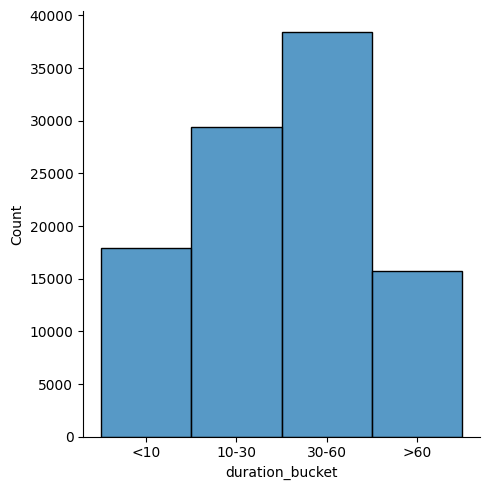

In [ ]:
# Create distribution plot using seaborn with specified bins
sns.displot(data=dfSpot, x='duration_bucket', bins=bins)

###Word Cloud of Episode and Show Descriptions

In [ ]:
# Add other stopwords

# Define a list of stopwords to add
new_stopwords = ['podcasts', 'show', 'https', 'anchor', 'app', 'fm', 'podcast', 'episode', 'sponsored', 'support']

# Add the new stopwords to the default set
STOPWORDS.update(new_stopwords)

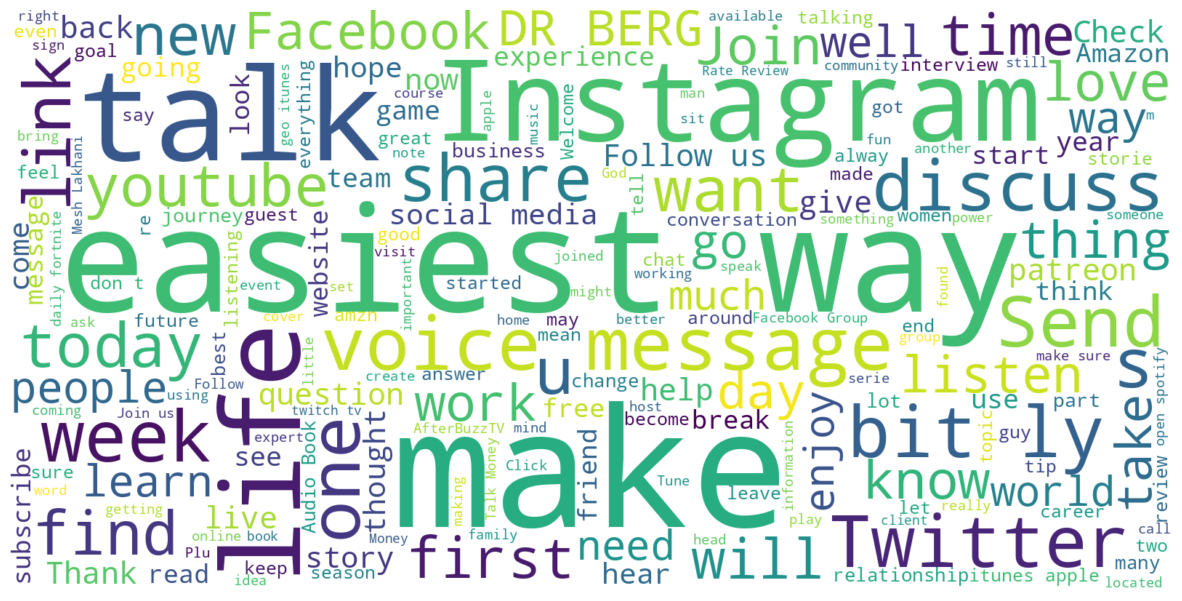

In [ ]:
# Word Cloud model of episode description text
text = " ".join(i for i in dfSpot.episode_description)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1600, height=800).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

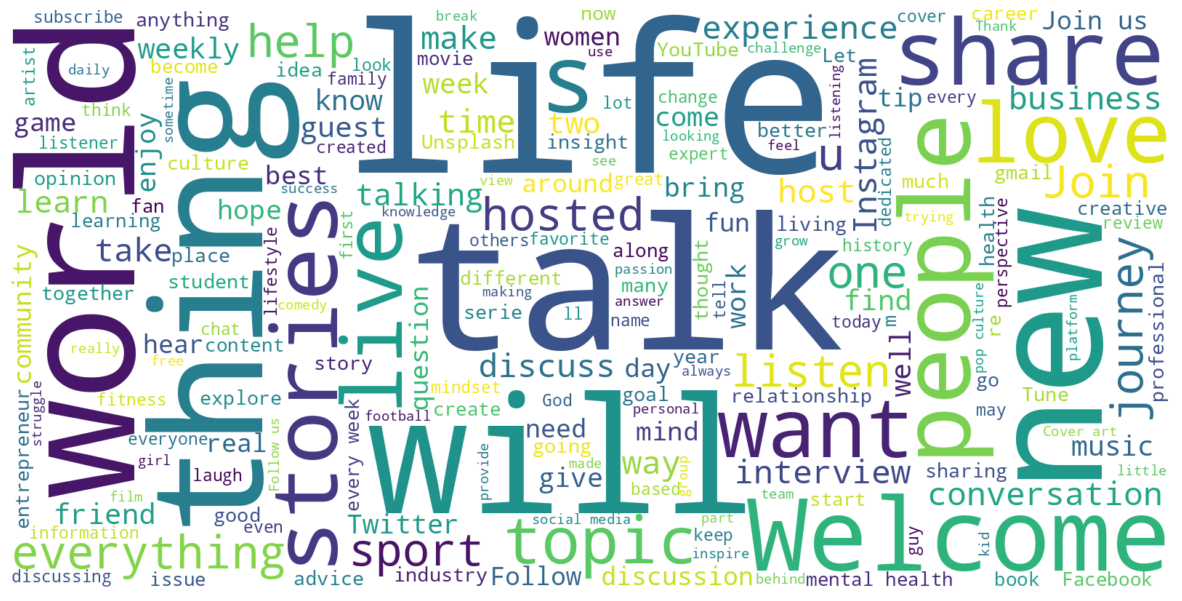

In [ ]:
# Word Cloud model of show description text
text = " ".join(i for i in dfSpot_sh.show_description)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1600, height=800).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Build Models


Because there is no user_id or review data, we will build a content-based filtering model.

### Episode Descriptions

Because Colab has limited memory, we can only run the model on a shortened dataframe. We create a new dataframe of the maximum amount of randomly-selected rows we can have without crashing the cosine similarity model.

In [ ]:
# Create shortened dataframe of n randomly-selected rows
dfSpot_new = dfSpot.sample(n = 55000, random_state=0, ignore_index=True)

In [ ]:
# Apply tfidf vectorizer to shortened dataframe
tfidf_wm_ep = TfidfVectorizer(analyzer='word', stop_words='english').fit_transform(dfSpot_new.episode_description)

In [ ]:
# Create a cosine similarity model
cosine_sim_ep = cosine_similarity(tfidf_wm_ep, tfidf_wm_ep)

### Show Descriptions


In [ ]:
tfidf_wm_sh = TfidfVectorizer(analyzer='word', stop_words='english').fit_transform(dfSpot_sh.show_description)

In [ ]:
cosine_sim_sh = cosine_similarity(tfidf_wm_sh, tfidf_wm_sh)
cosine_sim_sh.shape

(16989, 16989)

## Predict

### Similar Episodes




In [ ]:
indices_ep = pd.Series(dfSpot_new.index, index = dfSpot_new['episode_name'])

In [ ]:
def get_episode_recommendations(new_episode, min, max):
  idx = indices_ep[new_episode]
  sim_scores = list(enumerate(cosine_sim_ep[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  episode_indices = [i[0] for i in sim_scores]
  df = dfSpot_new.iloc[episode_indices].drop(dfSpot_new.loc[dfSpot_new['episode_name'] == new_episode].index[0])
  df = df[(df['duration'] >= min) & (df['duration'] <= max)]
  df['sim_score'] = pd.Series([i[1] for i in sim_scores], index=episode_indices)
  print('\nBased on episode: ' + new_episode +  ', we recommend: \n')
  return df[['episode_name', 'episode_description', 'duration', 'sim_score']].head(10)

In [ ]:
(dfSpot_new.iloc[[54992, 54994, 54987, 107,2000]])[['episode_name', 'episode_description', 'duration']]

,episode_name,episode_description,duration
54992,The Top 10 - Star Wars Battles,We are about to close the Skywalker saga with ...,86.048500
54994,27: Guinea Pig Sleeping Habits,"In this episode, I share with you how long gui...",8.199400
54987,Is Your All on the Altar?,Thank you for joining us for today's Rosary! W...,21.192850
107,Episode 490 - Packers Defense vs. Giants Offense,"On today's show, Nick & Maggie discuss whether...",37.406567
2000,Earth Week Night Quiz,"So, which of these is not a natural resource: ...",4.268400


In [ ]:
title = input("Enter episode name: ") 
min_length = float(input("Enter minimum episode length: "))
max_length = float(input("Enter maximum episode length: "))

get_episode_recommendations(title, min_length, max_length)

Enter episode name: 27: Guinea Pig Sleeping Habits
Enter minimum episode length: 2
Enter maximum episode length: 100

Based on episode: 27: Guinea Pig Sleeping Habits, we recommend: 



,episode_name,episode_description,duration,sim_score
52689,31: COMING SOON... Updates & Your Say!,"In this episode, I share what's involved with ...",10.205600,0.958454
2879,33: Inside my Medical Kit - What do I have & W...,"In this episode, I share what's inside my medi...",33.908250,0.920592
15083,39: 3 Things that Guinea Pigs can Teach Children,"In this episode, I share three things that gui...",12.459100,0.884789
28376,40: Getting a Guinea Pig for Christmas - What ...,"In this episode, I share the things that you n...",20.806100,0.869956
47106,35: All about Fleece - My favourite bedding ma...,"In this episode, I share my knowledge of fleec...",17.759783,0.811552
49466,46: The Great Guinea Pig Takeover! - 6 Fosters...,"In this episode, I share all the craziness tha...",32.273417,0.467591
20032,Money Week Night Jokes,Why did the football team break the piggy bank...,4.001517,0.165737
44184,Money Week Night Jokes (2-7-2020),Why did the football team break the piggy bank...,2.462033,0.165737
32557,FAMILY TIES,EPISODE 9! Brandon's Social Media: Facebook...,57.165500,0.162836
36971,THE PROBLEM WITH STAND UP COMEDY!,Episode 12! Brandon's Social Media: Faceboo...,59.174317,0.162637


### Similar Shows


In [ ]:
indices_sh = pd.Series(dfSpot_sh.index, index = dfSpot_sh['show_name'])

In [ ]:
def get_show_recommendations(new_show):
  idx = indices_sh[new_show]
  sim_scores = list(enumerate(cosine_sim_sh[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  show_indices = [i[0] for i in sim_scores]
  df = dfSpot_sh.iloc[show_indices].drop(index=dfSpot_sh.loc[dfSpot_sh['show_name'] == new_show].index[0])
  df['sim_score'] = pd.Series([i[1] for i in sim_scores], index=show_indices)
  print('\nBased on show: ' + new_show +  ', we recommend: \n')
  return df[['show_name', 'show_description', 'sim_score']].head(10)

In [ ]:
(dfSpot_sh.iloc[[1, 2, 3]])[['show_name', 'show_description']]

,show_name,show_description
1,Morning Cup Of Murder,Ever wonder what murder took place on today in...
2,Inside The 18 : A Podcast for Goalkeepers by G...,Inside the 18 is your source for all things Go...
3,Arrowhead Live!,Your favorite podcast for everything @Chiefs! ...


In [ ]:
title = input("Enter show name: ") 
get_show_recommendations(title)

## Hyperparameter Tuning

In [ ]:
# Define function to get average of cosine sim scores for given model

def get_avg_sim_score(cosine_sim):
  avg = list()
  for i in range(len(cosine_sim)):
    sim_scores = list(enumerate(cosine_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    scores = [i[1] for i in sim_scores]
    avg.append(average(scores))
  return average(avg)

In [ ]:
# Score of current model (n=55000)
get_avg_sim_score(cosine_sim_ep)

In [ ]:
# Create models of new sample size
n = [5000, 10000]
cosine_sim = list()

for i in n:
  dfSpot_new = dfSpot.sample(n = i, random_state=0, ignore_index=True)
  tfidf_wm_ep = TfidfVectorizer(analyzer='word', stop_words='english').fit_transform(dfSpot_new.episode_description)
  cosine_sim.append(cosine_similarity(tfidf_wm_ep, tfidf_wm_ep))

In [ ]:
# Scores for each new model
for score in cosine_sim:
  print('\nSample size: ' + str(score.shape[0]))
  print(get_avg_sim_score(score))

##Stakeholder Recommendations


Stakeholders

1.   Spotify
2.   Users




### Business Model:

*   "In 2018, 46% of Spotify's users were premium users, who generated 90% of its total revenues." From Stratgyzer.com
*   Convert free users to premium subscribers
*   Keep premium subscribers interested in new content


This model will accomplish this by giving consumers related content accurately based on their podcasts preferences.